The script follows the image classification (modeling) of the Paddy Disease, a Kaggle competition, as discussed in lecture 6 of the fastai course. This is a continuation of Paddy Disease Classification V1, which implements a better image model for improved classification.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
from fastai.imports import *
np.set_printoptions(linewidth=130)
import os
from pathlib import Path
path = Path('/kaggle/input/paddy-doctor/paddy-disease-classification')
path

Path('/kaggle/input/paddy-doctor/paddy-disease-classification')

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#6) [Path('/kaggle/input/paddy-doctor/paddy-disease-classification/sample_submission.csv'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/train_images'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/.jovianrc'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/.ipynb_checkpoints'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/train.csv'),Path('/kaggle/input/paddy-doctor/paddy-disease-classification/test_images')]

In [5]:
#Initial file size

check_files = path/'train_images'
files = get_image_files(check_files)

from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10407
Name: count, dtype: int64


The earlier version takes a long time in each epoch. This is primarily associated with image iteration. To iterate much more quickly (for testing purposes), all images need to be resized to half their height and width -- which reduces their number of pixels 4x. This should mean an around 4x increase in performance for training small models.

'resize_images' in fastai has a function which can do the same, whilst maintaining the folder structure of the data.

In [6]:
#Createing a new Path object pointing to a directory named sml, containing all resized images.
trn_path = Path('sml')

In [7]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

In [8]:
#Updated file size

check_files2 = trn_path
files2 = get_image_files(check_files2)

sizes = parallel(f, files2, n_workers=8)
pd.Series(sizes).value_counts()

(192, 256)    10407
Name: count, dtype: int64

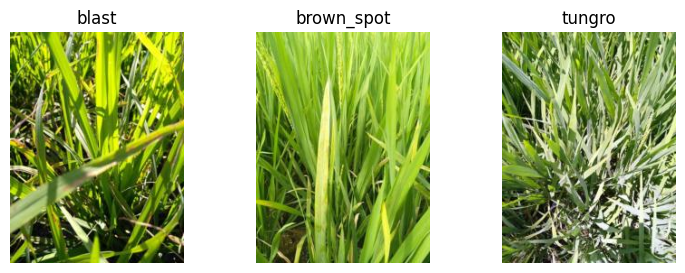

In [9]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

A function is created to generate the learning model (learn). This can be used to test different different architectures and image processing approaches (item and batch transforms).

item_tfms already resizes our images to small sizes, so this shouldn't impact the accuracy of the models much, if at all. 

lr=0.01 (See the previous script)

In [10]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [11]:
#resnet26d 
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.932906,1.578660,0.482941,00:16


epoch,train_loss,valid_loss,error_rate,time
0,1.287619,0.960477,0.304181,00:15
1,1.035053,0.620966,0.206631,00:15
2,0.708810,0.449249,0.151370,00:15
3,0.528111,0.381541,0.126862,00:15
4,0.427637,0.365428,0.120615,00:15


No (real) change in accuracy but substantial improvement in speed

**ConvNeXt model** is an improved vision model with v.good speed-accuracy trade-off, based on the benchmarking done in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning)

In [12]:
arch = 'convnext_small_in22k'

In [13]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.304538,0.785323,0.259491,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.662633,0.449032,0.135512,00:31
1,0.498304,0.363675,0.105718,00:31
2,0.314239,0.200715,0.062470,00:31
3,0.198548,0.157493,0.046132,00:31
4,0.129650,0.140236,0.042768,00:31


The convNext model shows a large improvement in the accuracy.

**Preprocessing Experiments**

In the earlier model (Resize(192, method='squish')) transform resizes images to a target size of 192 pixels. The method='squish' argument specifies that the image should be stretched or compressed to fit the exact target dimensions, ignoring the original aspect ratio.

Next, effect of different image preprocessing formats are tested, e.g., squish (a rectangular image into a square shape by changing its aspect ratio), crop, etc.

In [14]:
# Using 'crop' (default option) rather than 'squish'

learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))


epoch,train_loss,valid_loss,error_rate,time
0,1.317913,0.778301,0.245074,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.710787,0.479640,0.155694,00:31
1,0.537118,0.368627,0.117732,00:31
2,0.375179,0.258904,0.085055,00:31
3,0.237233,0.160290,0.047573,00:31
4,0.178357,0.156093,0.046132,00:31


Not a big effect

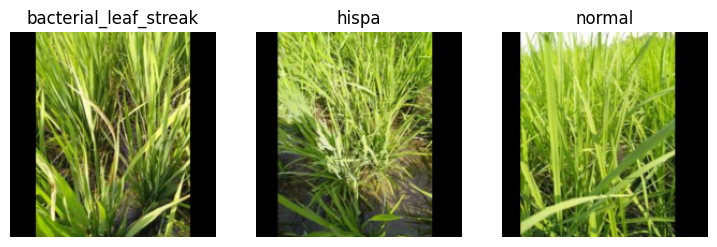

In [15]:
# Testing 'padding', which keeps all the original image without transforming it, as follows:

dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [16]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.261230,0.707270,0.228256,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.660390,0.426576,0.145603,00:36
1,0.503716,0.303245,0.094666,00:36
2,0.327092,0.263678,0.077367,00:36
3,0.198620,0.146177,0.045651,00:36
4,0.122196,0.136091,0.043248,00:36


Again, not a large influence!

**Test time augmentation**

TTA is defined as: "During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image."

First, the predictions and error rates w/o TTA are checked.

In [17]:
valid = learn.dls.valid #validation dataset (20% from dls)
preds,targs = learn.get_preds(dl=valid) #predicting on the validation set

In [18]:
error_rate(preds, targs)

#Produces the same error rate at the end of training, above

TensorBase(0.0432)

Here's what data augmentation does: the same image is augmented with different functions as sometimes flipped, zoomed, rotated, warped

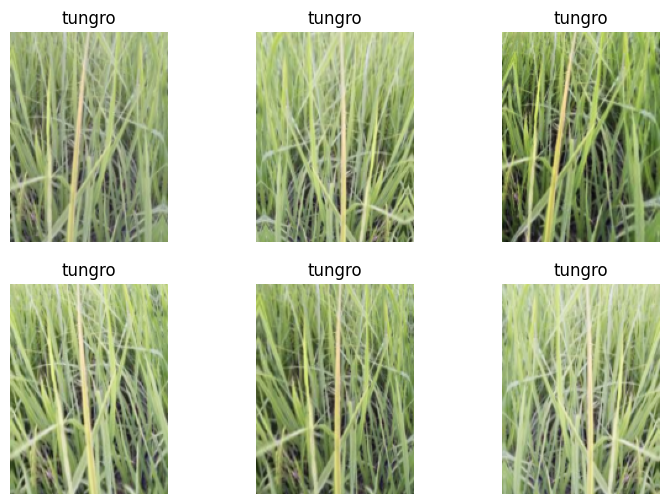

In [19]:
learn.dls.train.show_batch(max_n=6, unique=True)

The **tta()** function gets the average of predictions made for multiple different augmented versions of each image, along with the unaugmented original

In [20]:
tta_preds,_ = learn.tta(dl=valid)

In [21]:
error_rate(tta_preds, targs)

TensorBase(0.0365)

The accuracy is so far the best!

**Scaling up**

After finding a pretty good model and a preprocessing approach, the model is scaled up to larger images and more epochs. The traning path is switched back to the original un-resized images, and 12 epochs are used on the best settings so far, with larger final augmented images

In [22]:
trn_path = path/'train_images'

In [23]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.135616,0.632026,0.203268,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.543206,0.271347,0.082653,01:19
1,0.408861,0.246560,0.084575,01:19
2,0.321620,0.275846,0.086016,01:19
3,0.311479,0.279657,0.083614,01:19
4,0.244926,0.156057,0.050457,01:19
5,0.173868,0.153608,0.048534,01:19
6,0.133997,0.103080,0.030754,01:19
7,0.096795,0.133794,0.036521,01:19
8,0.074950,0.108364,0.027391,01:19
9,0.050382,0.095966,0.023066,01:18


Adding more epochs improved the accuracy. Next, including TTA:

In [24]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0221)

TTA provides a small but slightly better improvement

**Testing data**

In [25]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [26]:
preds,_ = learn.tta(dl=tst_dl)

We need to indices of the largest probability prediction in each row, since that's the index of the predicted disease. argmax in PyTorch gives us exactly that

The output for the test data (images) needs to be classified as per the largest probability prediction. The output can provide index of the predicted disease using 'argmax'

In [27]:
idxs = preds.argmax(dim=1)

These indices are then looked up in the vocab. Previous script used pandas for doing the same; here, a different approach is followed 

In [28]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [29]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
